In [4]:
#残務
#　地域とカテゴリーのマトリックスの偏りも見ておいたほうがよい
#　今はStatusのフラグで学習しているが、Pledged/Goalでゴール達成率を出して、それで学習して、一定の閾値を超える予想値をSuccessfulと判断するような手法は、より正確になるのではないか。達成率がぎりぎりのものと、余裕を持ってるものとで差をつけて学習した方がより本質に迫れるはずなので。（こういう分析手段って一般的？）

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#本ケースにおいて、正規化・標準化を行う意義は希薄と判断（無相関化は意義があるかもしれない）
import datetime
import codecs

In [5]:
#グラフ描画関数
def dataplot_func(pltdata):
    fig = plt.figure(figsize = (20,15))
    
    ax1 = fig.add_subplot(2,3,1)
    ax1.set_title('Goal Amount')
    ax1.hist(pltdata['goal'].values, density=True, bins=20)
    
    ax2 = fig.add_subplot(2,3,2)
    ax2.set_title('Funding Span')
    ax2.hist(pltdata['funding_span'].values, density=True)
    
    ax3 = fig.add_subplot(2,3,3)
    ax3.set_title('Daily Target')
    ax3.hist(pltdata['daily_goal'].values, density=True, bins=20)
    
    ax4 = fig.add_subplot(2,3,4)
    ax4.set_title('Currency')
    pltdata.groupby('currency')['state'].mean().plot.barh(ax=ax4)
    
    ax5 = fig.add_subplot(2,3,5)
    ax5.set_title('County')
    pltdata.groupby('country')['state'].mean().plot.barh(ax=ax5)
    
    ax6 = fig.add_subplot(2,3,6)
    ax6.set_title('Main Category')
    pltdata.groupby('main_category')['state'].mean().plot.barh(ax=ax6)
    
    print (pltdata.groupby('currency')['state'].mean().sort_values(ascending=False))
    print (pltdata.groupby('country')['state'].mean().sort_values(ascending=False))
    print (pltdata.groupby('main_category')['state'].mean().sort_values(ascending=False))
    
    plt.show()

def scatter_matrix(pltdata):
    pltdata2 = pltdata.copy()
    pltdata2.drop(['ID', 'name', 'category', 'deadline', 'launched', 'country'], axis=1)
    pd.plotting.scatter_matrix(pltdata2, figsize=(20,20))
    plt.show()

def vs_y_dataplot_func(pltdata):
    y_plt = pltdata['state'].values
    
    fig = plt.figure(figsize = (20,10))
    #sns.set()
    #sns.set_style('whitegrid')
    #sns.set_palette('gray')
    
    SF_flag = y_plt.astype(np.bool)
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('Goal Amount')
    ax1.set_xlabel("Success Flag")
    ax1.set_ylabel("Goal Amount")
    ax1.set_xticklabels(['Successful', 'Failed'])
    ax1.set_xticks([1, 2])
    x = pltdata['goal'].values
    ax1.violinplot([x[SF_flag],x[~SF_flag]])
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Funding Span')
    ax2.set_xlabel("Success Flag")
    ax2.set_ylabel("Funding Span")
    ax2.set_xticklabels(['Successful', 'Failed'])
    ax2.set_xticks([1, 2])
    x = pltdata['funding_span'].values
    ax2.violinplot([x[SF_flag],x[~SF_flag]])
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Daily Target')
    ax3.set_xlabel("Success Flag")
    ax3.set_ylabel("Daily Target")
    ax3.set_xticklabels(['Successful', 'Failed'])
    ax3.set_xticks([1, 2])
    x = pltdata['daily_goal'].values
    ax3.violinplot([x[SF_flag],x[~SF_flag]])
    
    plt.show()

#外れ値処理関数　→　結局データフレームで呼び出す場合とNPArrayで呼び出す場合があって、関数化は難しいか。ほぐすかも。マスクだけ処理して返すか？
def outlier_remove_func(dataframe):
    mask = ((dataframe['goal'] < dataframe['goal'].quantile(0.9)) & (dataframe['funding_span'] < dataframe['funding_span'].quantile(0.99)))
    dataframe_ex_outlier = dataframe[mask]
    lb = LabelBinarizer()
    main_category_onehot = lb.fit_transform(dataframe_ex_outlier['main_category'])
    main_category_list = lb.classes_
    return dataframe_ex_outlier, main_category_onehot, main_category_list


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015/10/9,1000.0,2015/8/11 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017/11/1,30000.0,2017/9/2 4:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013/2/26,45000.0,2013/1/12 0:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012/4/16,5000.0,2012/3/17 3:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015/8/29,19500.0,2015/7/4 8:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


Original Size = 378376

ex. live & undefined Size = 372020

currency
USD    0.375763
HKD    0.370497
GBP    0.361546
SGD    0.337761
DKK    0.329091
NZD    0.311715
SEK    0.293203
CAD    0.282753
AUD    0.258559
CHF    0.251007
MXN    0.240876
NOK    0.232194
EUR    0.229722
JPY    0.225806
Name: state, dtype: float64
country
N,0"    0.448718
US      0.375704
HK      0.370497
GB      0.361387
SG      0.337761
DK      0.328168
FR      0.314731
NZ      0.311715
LU      0.311475
SE      0.293372
CA      0.282644
IE      0.258750
AU      0.258696
BE      0.251240
CH      0.251007
MX      0.240876
NO      0.231429
DE      0.229320
JP      0.225806
ES      0.221019
NL      0.217867
AT      0.183849
IT      0.156898
Name: state, dtype: float64
main_category
Dance           0.623599
Theater         0.601105
Comics          0.543592
Music           0.489717
Art             0.411659
Film & Video    0.378596
Games           0.358231
Design          0.354480
Publishing      0.314501
Photography  

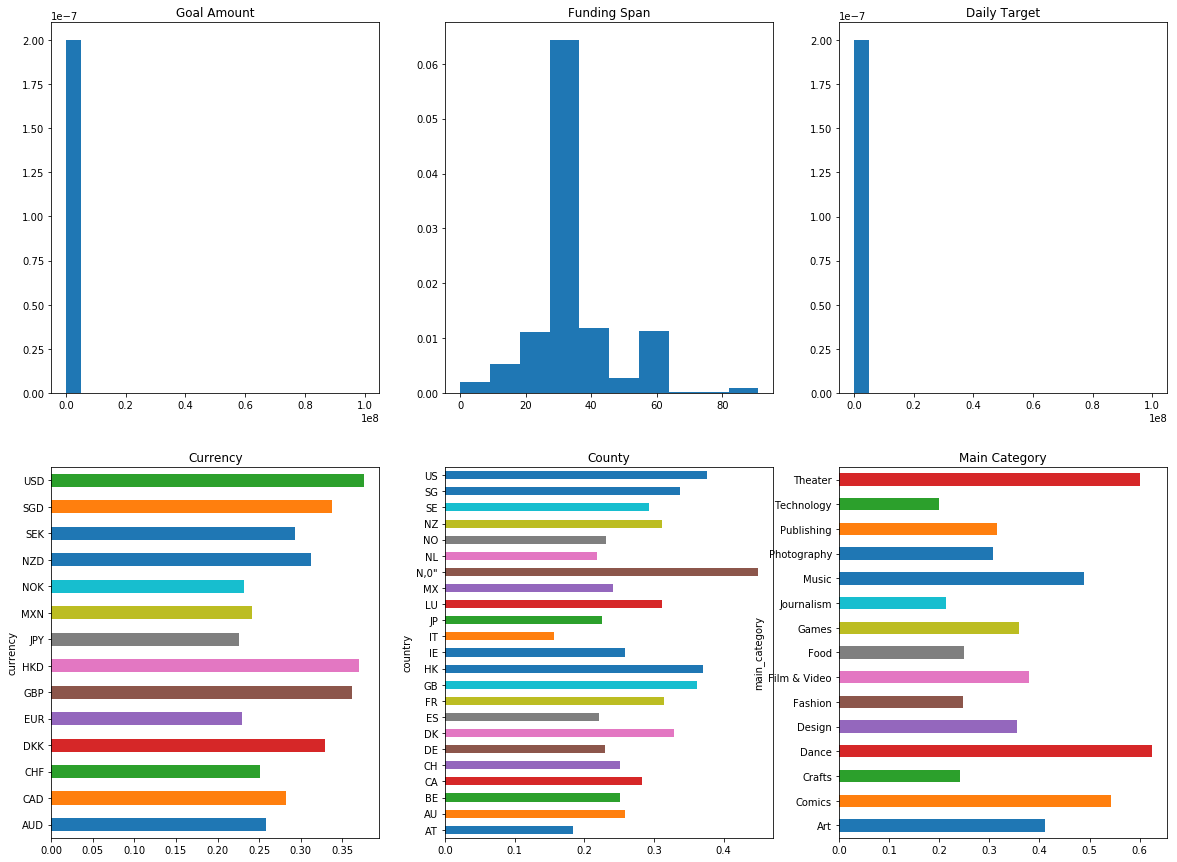

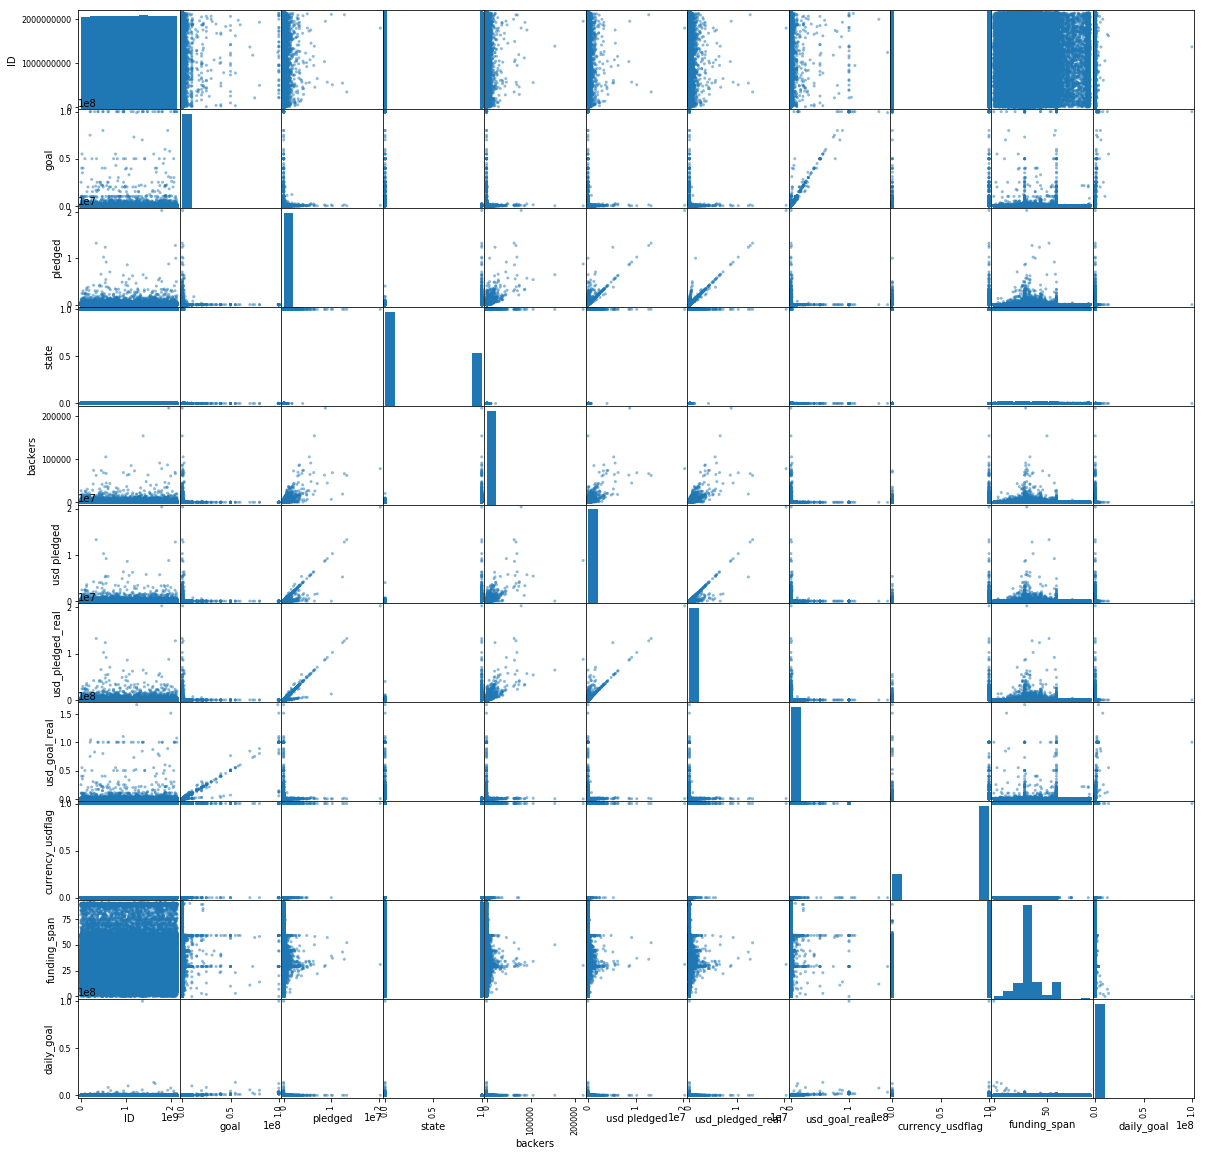

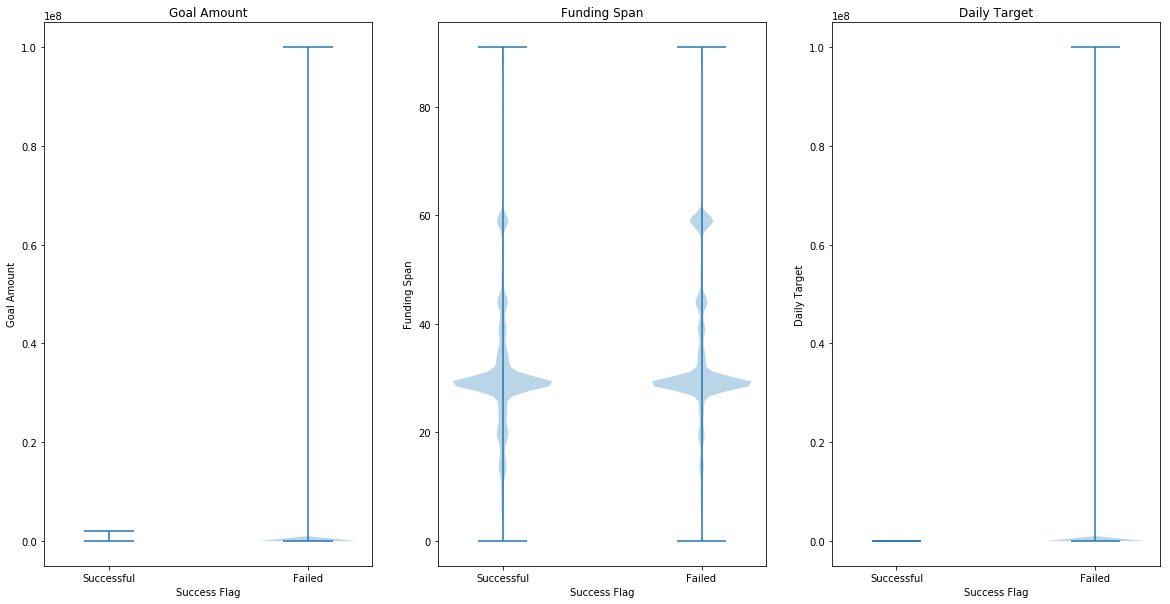

In [6]:
#カテゴリー、通貨、国、ゴールの大きさ、ローンチ、デッドライン　くらいしか事前推定の要素として使えない。
#ローンチからデッドラインまでの日数は有効かもしれない。またゴールをその日数で割るというのも、1日あたりの獲得金額を表現でき、有効かもしれない。

#df_deals = pd.read_csv("./kickstarter-projects/ks-projects-201801_short.csv")[['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]
#df_deals = pd.read_csv("./kickstarter-projects/ks-projects-201801.csv")[['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]
#下記はよくわかっていないながらも、ググって出てきた手法で、エンコードがらみのファイル読み込みエラーを解消（一度エクセルでバグ行を取り除いたことでエンコードがらみがおかしくなった。なお外れ値処理ではない。あくまで物理的破損行の除去のみ。）
with codecs.open("./kickstarter-projects/ks-projects-201801_bugcut_SJIS.csv", "r", "Shift-JIS", "ignore") as file:
    df_deals = pd.read_table(file, delimiter=",")
display(df_deals.head())
data_records_count = df_deals['ID'].size
print ("Original Size = " + str(data_records_count))
print ()

#stateでliveとundefinedは分析対象外とする。その他については、successful以外はfailed扱いとして、二値分類問題とする。
mask = ((df_deals['state'] == 'live') | (df_deals['state'] == 'undefined'))
df_deals = df_deals[~mask]
data_records_count = df_deals['ID'].size
print ("ex. live & undefined Size = " + str(data_records_count))
print ()

#stateをフラグ化。
df_deals['state'] = (df_deals['state'] == 'successful')*1

#CurrencyをUSD or notでフラグ化。
df_deals['currency_usdflag'] = (df_deals['currency'] == 'USD')*1

#main_categoryをOne Hot Dataへ。
lb = LabelBinarizer()
main_category_onehot = lb.fit_transform(df_deals['main_category'])

#ローンチからデッドラインまでの日数、および1日あたり目標金額を計算し新たな説明変数へ。
df_deals['launched_dt'] = pd.to_datetime(df_deals.launched)
df_deals['deadline_dt'] = pd.to_datetime(df_deals.deadline)
df_deals['funding_span'] = (df_deals.deadline_dt - df_deals.launched_dt).dt.days
df_deals['daily_goal'] = df_deals.goal / (df_deals.funding_span + 1)

#仕上がったデータセット（外れ値対応前）をまずは描画
#単純な分布確認
dataplot_func(df_deals)
scatter_matrix(df_deals)
#Statusとの相関性確認
vs_y_dataplot_func(df_deals)


329455


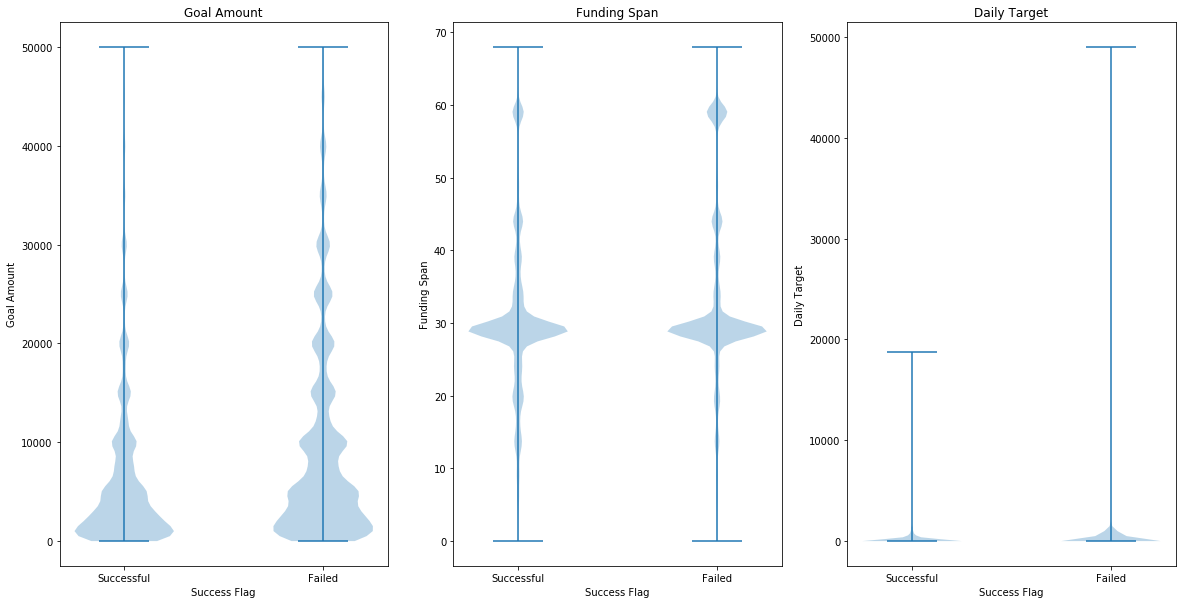

In [7]:
#外れ値を一旦除去して再確認
#print (df_deals['goal'].quantile(0.9))
#print (df_deals['funding_span'].quantile(0.99))
df_deals_ex_outlier, main_category_onehot, main_category_list = outlier_remove_func(df_deals)
data_records_count = df_deals_ex_outlier['ID'].size
print (data_records_count)

vs_y_dataplot_func(df_deals_ex_outlier)


w0 = 10.254
w1(Funding Span) = -0.317
w2(Daily Goal) = -0.047
w3(USD) = 1.822
w4(Art) = -5.258
w5(Comics) = 3.625
w6(Crafts) = -78.689
w7(Dance) = 124.600
w8(Design) = -3.715
w9(Fashion) = -8.563
w10(Film & Video) = -3.697
w11(Food) = -7.938
w12(Games) = -4.440
w13(Journalism) = -56.486
w14(Music) = -2.144
w15(Photography) = -7.038
w16(Publishing) = -6.400
w17(Technology) = -32.343
w18(Theater) = 98.740


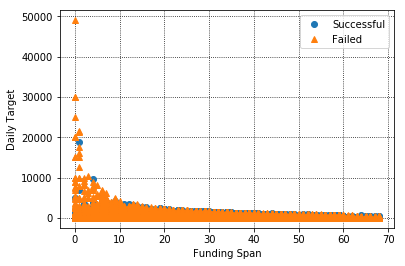

対数尤度 = -12.603
正答率 = 63.512%
適合率 = 63.525%
再現率 = 94.958%
F1値 = 76.125%


,予測 = 調達成功,予測 = 調達失敗
正解 = 調達成功,17600,110036
正解 = 調達失敗,10176,191643


In [8]:
#まずは試しで、外れ値を除去した全体に対してロジスティック回帰をしてみる（参考値でしかない）
y = df_deals_ex_outlier['state'].values
funding_span = df_deals_ex_outlier['funding_span'].values
daily_goal = df_deals_ex_outlier['daily_goal'].values
currency_usdflag = df_deals_ex_outlier['currency_usdflag'].values
funding_span_T = funding_span.reshape(-1,1)
daily_goal_T = daily_goal.reshape(-1,1)
currency_usdflag_T = currency_usdflag.reshape(-1,1)
X = np.c_[funding_span_T, daily_goal_T, currency_usdflag_T, main_category_onehot]

clf = SGDClassifier(loss='log', penalty='none', max_iter=100, fit_intercept=True, random_state=1234)
clf.fit(X, y)

#w0 = clf.intercept_[0]
print ("w0 = {:.3f}".format(clf.intercept_[0]))
print ("w1(Funding Span) = {:.3f}".format(clf.coef_[0,0]))
print ("w2(Daily Goal) = {:.3f}".format(clf.coef_[0,1]))
print ("w3(USD) = {:.3f}".format(clf.coef_[0,2]))
for i in range(len(X[0])-3):
    print ("w"+str(i+4)+"("+main_category_list[i]+") = {:.3f}".format(clf.coef_[0,i+3]))

x1 = funding_span
x2 = daily_goal
SF_flag = y.astype(np.bool)
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(x1[SF_flag], x2[SF_flag], 'o', color='C0', label='Successful')
plt.plot(x1[~SF_flag], x2[~SF_flag], '^', color='C1', label='Failed')

#line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
#line_y = - line_x * w1 / w2 - w0 / w2
#plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
#plt.xlim([np.min(x1) - 1, np.max(x1) + 1])
#plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')
plt.xlabel("Funding Span")
plt.ylabel("Daily Target")
plt.show()

y_est = clf.predict(X)
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
precision, recall, f1_score, _ = precision_recall_fscore_support(y,y_est)
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}%'.format(100 * f1_score[0]))
conf_mat = pd.DataFrame(confusion_matrix(y, y_est,labels=[1,0]), 
                        index=['正解 = 調達成功', '正解 = 調達失敗'], 
                        columns=['予測 = 調達成功', '予測 = 調達失敗'])
display(conf_mat)


In [9]:
#ロジスティック回帰
n_split = 5
sum_logloss = 0
sum_accuracy = 0
sum_precision = 0
sum_recall = 0
sum_f1_score = 0
split_num = 1

#一旦、外れ値処理前のデータセットに戻す
y = df_deals['state'].values
funding_span = df_deals['funding_span'].values
daily_goal = df_deals['daily_goal'].values
currency_usdflag = df_deals['currency_usdflag'].values
funding_span_T = funding_span.reshape(-1,1)
daily_goal_T = daily_goal.reshape(-1,1)
currency_usdflag_T = currency_usdflag.reshape(-1,1)
main_category_onehot = lb.fit_transform(df_deals['main_category'])
X = np.c_[funding_span_T, daily_goal_T, currency_usdflag_T, main_category_onehot]
results_fold = np.zeros((n_split, len(X[0])+1))
display_results_column = np.array([])
display_results_index = ["w0","w1(Funding Span)","w2(Daily Goal)","w3(USD)"]

for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    #Trainデータの方は選んだ後に外れ値を外したい。Testはありのままであるべき。
    #関数に束ねられるよう、カラムを番号で指定できるようにする？
    #mask = ((dataframe['goal'] < dataframe['goal'].quantile(0.9)) & (dataframe['funding_span'] < dataframe['funding_span'].quantile(0.99)))
    #dataframe_ex_outlier = dataframe[mask]
    #lb = LabelBinarizer()
    #main_category_onehot = lb.fit_transform(dataframe_ex_outlier['main_category'])
    #main_category_list = lb.classes_
    
    clf.fit(X_train, y_train)
    print ("w0 = {:.3f}".format(clf.intercept_[0]))
    print ("w1(Funding Span) = {:.3f}".format(clf.coef_[0,0]))
    print ("w2(Daily Goal) = {:.3f}".format(clf.coef_[0,1]))
    print ("w3(USD) = {:.3f}".format(clf.coef_[0,2]))
    results_temp = [clf.intercept_[0],clf.coef_[0,0],clf.coef_[0,1],clf.coef_[0,2]]
    for i in range(len(X[0])-3):
        print ("w"+str(i+4)+"("+main_category_list[i]+") = {:.3f}".format(clf.coef_[0,i+3]))
        results_temp = np.hstack((results_temp, clf.coef_[0,i+3]))
        if split_num == 1:
            display_results_index = np.hstack((display_results_index, ("w"+str(i+4)+"("+main_category_list[i]+")")))
    y_test_est = clf.predict(X_test)
    logloss_fold = - log_loss(y_test, y_test_est)
    accuracy_fold = 100 * accuracy_score(y_test, y_test_est)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test,y_test_est)
    print('対数尤度 = {:.3f}'.format(logloss_fold))
    print('正答率 = {:.3f}%'.format(accuracy_fold))
    print('適合率 = {:.3f}%'.format(100 * precision[0]))
    print('再現率 = {:.3f}%'.format(100 * recall[0]))
    print('F1値 = {:.3f}%'.format(100 * f1_score[0]))
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_est,labels=[1,0]), 
                        index=['正解 = 調達成功', '正解 = 調達失敗'], 
                        columns=['予測 = 調達成功', '予測 = 調達失敗'])
    display(conf_mat)
    
    print("Fold %s Done"%split_num)
    print()
    
    display_results_column = np.hstack((display_results_column, ("Fold "+str(split_num))))
    results_fold[split_num-1] = results_temp
    sum_logloss += logloss_fold
    sum_accuracy += accuracy_fold
    sum_precision += 100 * precision[0]
    sum_recall += 100 * recall[0]
    sum_f1_score += 100 * f1_score[0]
    split_num += 1

mean_logloss = sum_logloss / n_split
mean_accuracy = sum_accuracy / n_split
mean_precision = sum_precision / n_split
mean_recall = sum_recall / n_split
mean_f1_score = sum_f1_score / n_split
print("Cross Validation Log_Loss = {:.3f}".format(mean_logloss))
print("Cross Validation Accuracy = {:.3f}%".format(mean_accuracy))
print("Cross Validation Precision = {:.3f}%".format(mean_precision))
print("Cross Validation Recall = {:.3f}%".format(mean_recall))
print("Cross Validation F1 Score = {:.3f}%".format(mean_f1_score))


w0 = 1715.538
w1(Funding Span) = -74.231
w2(Daily Goal) = -28.544
w3(USD) = 839.737
w4(Art) = -47.518
w5(Comics) = 367.729
w6(Crafts) = -385.455
w7(Dance) = 199.352
w8(Design) = 629.260
w9(Fashion) = -410.363
w10(Film & Video) = 531.974
w11(Food) = -138.595
w12(Games) = 409.441
w13(Journalism) = -166.834
w14(Music) = 794.090
w15(Photography) = -216.614
w16(Publishing) = -353.376
w17(Technology) = -37.340
w18(Theater) = 539.788
対数尤度 = -12.132
正答率 = 64.874%
適合率 = 65.305%
再現率 = 95.586%
F1値 = 77.596%


,予測 = 調達成功,予測 = 調達失敗
正解 = 調達成功,3010,24045
正解 = 調達失敗,2090,45259


Fold 1 Done

w0 = 2305.748
w1(Funding Span) = 2693.994
w2(Daily Goal) = -213.987
w3(USD) = 1512.065
w4(Art) = 40.858
w5(Comics) = 406.303
w6(Crafts) = -396.866
w7(Dance) = 214.758
w8(Design) = 655.599
w9(Fashion) = -426.002
w10(Film & Video) = 719.553
w11(Food) = -143.368
w12(Games) = 528.787
w13(Journalism) = -181.550
w14(Music) = 1023.960
w15(Photography) = -242.700
w16(Publishing) = -424.746
w17(Technology) = -30.927
w18(Theater) = 562.091
対数尤度 = -16.812
正答率 = 51.324%
適合率 = 75.439%
再現率 = 35.507%
F1値 = 48.287%


,予測 = 調達成功,予測 = 調達失敗
正解 = 調達成功,21278,5505
正解 = 調達失敗,30712,16909


Fold 2 Done

w0 = 2063.370
w1(Funding Span) = -84.970
w2(Daily Goal) = -66.082
w3(USD) = 1395.016
w4(Art) = 81.435
w5(Comics) = 372.134
w6(Crafts) = -419.440
w7(Dance) = 208.274
w8(Design) = 654.570
w9(Fashion) = -448.322
w10(Film & Video) = 724.308
w11(Food) = -234.158
w12(Games) = 492.869
w13(Journalism) = -171.613
w14(Music) = 987.171
w15(Photography) = -252.481
w16(Publishing) = -442.409
w17(Technology) = -85.042
w18(Theater) = 596.074
対数尤度 = -12.157
正答率 = 64.803%
適合率 = 65.291%
再現率 = 96.430%
F1値 = 77.863%


,予測 = 調達成功,予測 = 調達失敗
正解 = 調達成功,2161,24483
正解 = 調達失敗,1705,46055


Fold 3 Done

w0 = 1970.137
w1(Funding Span) = -78.656
w2(Daily Goal) = -43.970
w3(USD) = 1302.514
w4(Art) = 86.017
w5(Comics) = 319.056
w6(Crafts) = -391.386
w7(Dance) = 251.360
w8(Design) = 551.163
w9(Fashion) = -449.038
w10(Film & Video) = 750.250
w11(Food) = -213.186
w12(Games) = 432.063
w13(Journalism) = -171.535
w14(Music) = 1002.749
w15(Photography) = -234.290
w16(Publishing) = -454.480
w17(Technology) = -61.195
w18(Theater) = 552.590
対数尤度 = -12.123
正答率 = 64.900%
適合率 = 65.751%
再現率 = 94.285%
F1値 = 77.474%


,予測 = 調達成功,予測 = 調達失敗
正解 = 調達成功,3377,23394
正解 = 調達失敗,2722,44911


Fold 4 Done

w0 = 1976.473
w1(Funding Span) = -41.109
w2(Daily Goal) = -5.896
w3(USD) = 1348.476
w4(Art) = 23.998
w5(Comics) = 377.449
w6(Crafts) = -416.435
w7(Dance) = 237.664
w8(Design) = 606.245
w9(Fashion) = -441.466
w10(Film & Video) = 768.613
w11(Food) = -241.298
w12(Games) = 507.071
w13(Journalism) = -183.881
w14(Music) = 970.161
w15(Photography) = -241.355
w16(Publishing) = -410.086
w17(Technology) = -149.100
w18(Theater) = 568.894
対数尤度 = -14.737
正答率 = 57.332%
適合率 = 77.715%
再現率 = 47.100%
F1値 = 58.653%


,予測 = 調達成功,予測 = 調達失敗
正解 = 調達成功,20140,6457
正解 = 調達失敗,25290,22517


Fold 5 Done

Cross Validation Log_Loss = -13.592
Cross Validation Accuracy = 60.646%
Cross Validation Precision = 69.900%
Cross Validation Recall = 73.782%
Cross Validation F1 Score = 67.975%


In [11]:
#SVM
n_split = 5
sum_logloss = 0
sum_accuracy = 0
sum_precision = 0
sum_recall = 0
sum_f1_score = 0
sum_score = 0
split_num = 1

#一旦、外れ値処理前のデータセットに戻す
y = df_deals['state'].values
funding_span = df_deals['funding_span'].values
daily_goal = df_deals['daily_goal'].values
currency_usdflag = df_deals['currency_usdflag'].values
funding_span_T = funding_span.reshape(-1,1)
daily_goal_T = daily_goal.reshape(-1,1)
currency_usdflag_T = currency_usdflag.reshape(-1,1)
main_category_onehot = lb.fit_transform(df_deals['main_category'])
X = np.c_[funding_span_T, daily_goal_T, currency_usdflag, main_category_onehot]

for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    #Trainデータの方は選んだ後に外れ値を外したい。Testはありのままであるべき。
    #関数に束ねられるよう、カラムを番号で指定できるようにする？
    #mask = ((dataframe['goal'] < dataframe['goal'].quantile(0.9)) & (dataframe['funding_span'] < dataframe['funding_span'].quantile(0.99)))
    #dataframe_ex_outlier = dataframe[mask]
    #lb = LabelBinarizer()
    #main_category_onehot = lb.fit_transform(dataframe_ex_outlier['main_category'])
    #main_category_list = lb.classes_
    
    #parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5]}
    parameters = {'kernel': 'rbf', 'C': 5}
    #model = SVC()
    #clf2_1 = GridSearchCV(model, parameters, cv=3,)
    #clf2_1.fit(X_train, y_train)
    #print(clf2_1.best_params_, clf2_1.best_score_)
    #clf2_2 = SVC(**clf2_1.best_params_)
    clf2_2 = SVC(kernel='rbf', C=5)
    clf2_2.fit(X_train, y_train)
    score_fold = 100 * clf2_2.score(X_test, y_test)
    print('識別精度 = {:.3f}'.format(score_fold))
    
    print("Fold %s Done"%split_num)
    print()
    
    sum_score += score_fold
    split_num += 1

mean_score = sum_score / n_split
print("Cross Validation Score = {:.3f}".format(mean_score))


識別精度 = 67.023
Fold 1 Done

識別精度 = 67.240
Fold 2 Done

識別精度 = 67.234
Fold 3 Done

識別精度 = 67.244
Fold 4 Done

識別精度 = 67.267
Fold 5 Done

Cross Validation Score = 67.201
